In [1]:
import cbs
import torch
import torch.nn as nn
import torch.nn.functional as F
import ctraining_data

# basic RESNET style convolution block, 
# these blocks make up the bulk of the network
class SimpleResidualConv2D(nn.Module):
    def __init__(self, channels: int, H: int, W: int, kernel_size: int, device='cpu'):
        super().__init__()
        self.device = device
        self.params = nn.ParameterList()
        self.modules = []
        pad = int((kernel_size-1)//2)
        self.conv1 = nn.LazyConv2d(channels, kernel_size, padding=pad, groups=1, device=device, bias=False)
        self.modules.append(self.conv1)
        self.params.extend(self.conv1.parameters())
        self.bn1 = nn.LazyBatchNorm2d(device=device)
        self.modules.append(self.bn1)
        self.params.extend(self.bn1.parameters())
        self.conv2 = nn.LazyConv2d(channels, kernel_size, padding=pad, groups=1, device=device, bias=False)
        self.modules.append(self.conv2)
        self.params.extend(self.conv2.parameters())
        self.bn2 = nn.LazyBatchNorm2d(device=device)
        self.modules.append(self.bn2)
        self.params.extend(self.bn2.parameters())
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        return F.relu(Y)+X
    
    def parameters(self):
        return self.params
    
    def to(self, device):
        for param in self.parameters():
            param.to(device)
        for module in self.modules:
            module.to(device)
            for param in module.parameters():
                param.to(device)
        self.device = device

# The "JoeyBlock" chains a SimpleResidualConv2D unit with a 1x1 convolution, merely to 
# introduce an extra layer of full-connections between channels.
# This might be over-kill
class JoeyBlock(nn.Module):
    def __init__(self, channels_in, 
                 channels_out, 
                 Hin, Win, 
                 ckernel_size,
                 ckernel_padding,
                 device = 'cpu'):
        super().__init__()
        self.device = device
        self.modules = []
        self.params = nn.ParameterList()
        self.channels_in = channels_in
        self.channels_out = channels_out
        self.res = SimpleResidualConv2D(channels_in, Hin, Win, ckernel_size, device=device)
        self.modules.append(self.res)
        self.params.extend(self.res.parameters())
        self.conv = nn.LazyConv2d(channels_out, ckernel_size, padding=ckernel_padding, device=device)
        self.modules.append(self.conv)
        self.params.extend(self.conv.parameters())
    
    def forward(self, X):
        return F.relu(self.conv(self.res(X)))
    
    def parameters(self):
        return self.params
    
    def to(self, device):
        for param in self.parameters():
            param.to(device)
        for module in self.modules:
            module.to(device)
            for param in module.parameters():
                param.to(device)
        self.device = device

# "JoeyNet" consists of a series of "JoeyBlocks", followed by a head stage
# consisting of 3 fully-connected layers that consume the flattened convolution channels.
class JoeyNet(nn.Module):
    def __init__(self, channels_in, Hin, Win, num_blocks, ckernel_size, ckernel_padding, pkernel_size, device='cpu'):
        super().__init__()
        self.device = device
        self.params = nn.ParameterList()
        self.modules = []
        features_out = channels_in-1
        self.blocks = [] 
        for i in range(num_blocks):
            block = JoeyBlock(channels_in, channels_in, Hin, Win, ckernel_size, ckernel_padding, device=device)
            self.modules.append(block)
            self.blocks.append(block)
            self.params.extend(block.parameters())
        self.pool = nn.MaxPool2d(pkernel_size)
        self.modules.append(self.pool)
        self.params.extend(self.pool.parameters())
        self.fc = []
        for i in range(1,4):
            fc = nn.LazyLinear(features_out, device=device)
            self.modules.append(fc)
            self.fc.append(fc)
            self.params.extend(fc.parameters())
    
    """
    Inputs to the forward pass of the network
    maps: a (N+1, H, W) tensor.
        - the first channel is a map of the empty environment
        - the remaining channels encode A* shortest paths for single agents that start
            on the boundary, and merely the goal location of all other agents. Hence,
            there is uncertainty built into the model.

    heuristic: a (N,) tensor containing the heuristic estimate for the shortest paths
        each agent that starts on the boundary. This is added to the output of
        the network, so that in effect, the network learns a "correction" to path-lengths
        predicted by A*.
    
    output_mask: a (N,) tensor of 1's and 0's, used to mask (zero) the output channels of 
        network which are associated with agents who's initial position in the environment
        is not known, but whos goal positions are known.
    """
    def forward(self, maps, heuristic, output_mask):
        Y = maps
        for i in range(len(self.blocks)):
            Y = self.blocks[i](Y)
        Y = self.pool(Y)
        Y = torch.flatten(Y, start_dim=1)
        for i in range(len(self.fc)-1):
            Y = F.relu(self.fc[i](Y))
        Y = self.fc[-1](Y)
        return output_mask*(heuristic + Y)
    
    def parameters(self):
        return self.params
    
    def to(self, device):
        for param in self.parameters():
            param.to(device)
        for module in self.modules:
            module.to(device)
            for param in module.parameters():
                param.to(device)
        self.device=device
        

In [2]:
"""
Import the training datasets
"""
import ctraining_data
import torch.optim as optim
from torch.utils.data import DataLoader
datafolders = ['data/train/fold1', 'data/train/fold2', 'data/train/fold3']
datasets = [ctraining_data.ColumnLatticeDataset(folder) for folder in datafolders]
batch_size = 100

In [3]:
# inspecting data to get the tensor shapes
features, labels = datasets[0][0]
maps, heuristic, mask = features
maps.size()

torch.Size([14, 14, 14])

In [62]:
"""
Construct the network. In this test, there are N=13 agents maximum
in the environment at any given time. This results in N+1=14 input channels.

I used 10 "JoeyBlocks" to construct the body of the network. They arent massive, but 
it may be overlarge. I'm not sure.

Inside the "JoeyBlocks" are convolution channels, the kernel size is set by ckernel_size.
These blocks, due to their residual nature, include padding to maintain the channel dimensions.
"""
channels_in = 14
Hin = 14
Win = 14
ckernel_size = 5
ckernel_padding = 1
pkernel_size = 2
num_blocks = 3
model = JoeyNet(channels_in, Hin, Win, num_blocks, ckernel_size, ckernel_padding, pkernel_size)
model.to('cuda:0')

# # note that multiple processes can be assigned in this constructor,
# # so that loading of large batches is sped up (this is a good idea when doing GPU training)
dataloader = DataLoader(datasets[0], batch_size=10, num_workers=0)

# # run a forward pass with gradients disabled to initialize lazy modules
features, labels = next(iter(dataloader))
maps, heuristic, mask = features
maps = maps.cuda('cuda:0')
heuristic = heuristic.cuda('cuda:0')
mask = mask.cuda('cuda:0')
labels = labels.cuda('cuda:0')
with torch.no_grad():
    model(maps, heuristic, mask)

c:\Users\Joseph\Documents\multirobot_planning\cbs\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [63]:
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()

0

In [64]:
# Using ADAM as our optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# for parameter in model.parameters():
    # print(parameter.device)

# Sum of squared errors as loss function
loss_fn = nn.MSELoss(reduction='sum')

# Training for 20 epochs
training_datasets = [datasets[0], datasets[1]]
validation_set = datasets[2]
batch_size = 1000
dataloaders = [DataLoader(dataset, batch_size=batch_size, pin_memory=True, pin_memory_device='cuda:0') for dataset in training_datasets]
validation_loader = DataLoader(validation_set, batch_size=batch_size, pin_memory=True, pin_memory_device='cuda:0')
N_training_examples = sum([len(dataset) for dataset in training_datasets])
N_validation_examples = len(validation_set)

In [65]:
epochs = 3
batch_losses = []
epoch_losses = torch.zeros((epochs, 2), requires_grad=False)
validation_losses = torch.zeros((epochs,2), requires_grad=False)
total_batches = 0
for i in range(epochs):
    count = 0
    current_epoch_batches = 0
    batch_loss = 0
    print("Training...")
    for dataloader in dataloaders:
        for features, labels in iter(dataloader):
            for parameter in model.parameters():
                parameter.grad = None
            current_epoch_batches += 1
            total_batches += 1
            count += labels.size()[0]
            maps = features[0].cuda('cuda:0')
            heuristic = features[1].cuda('cuda:0')
            mask = features[2].cuda('cuda:0')
            Y = labels.cuda('cuda:0')
            output = model(maps, heuristic, mask)
            loss = loss_fn(output, Y)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.cpu().item()/labels.size()[0])
            if (current_epoch_batches % 10 == 0):
                 print(f'Epoch Progress: {int(count/N_training_examples*100)}%, Last Batch Loss: {batch_losses[-1]}')
    
    print('Calculating Training Loss...')
    with torch.no_grad():
        epoch_loss = 0
        for dataloader in dataloaders:
            for features, labels in iter(dataloader):
                count += labels.size()[0]
                maps = features[0].cuda('cuda:0')
                heuristic = features[1].cuda('cuda:0')
                mask = features[2].cuda('cuda:0')
                Y = labels.cuda('cuda:0')
                output = model(maps, heuristic, mask)
                loss = loss_fn(output, Y)
                epoch_loss += loss.cpu().item()
        epoch_losses[i, 0] = epoch_loss/N_training_examples
        epoch_losses[i,1] = total_batches
        print(f'Training Loss: {epoch_losses[i,0]}')

    print('Calculating Validation Loss...')
    with torch.no_grad():
        validation_loss = 0
        for features, labels in iter(validation_loader):
            count += labels.size()[0]
            maps = features[0].cuda('cuda:0')
            heuristic = features[1].cuda('cuda:0')
            mask = features[2].cuda('cuda:0')
            Y = labels.cuda('cuda:0')
            output = model(maps, heuristic, mask)
            loss = loss_fn(output, Y)
            validation_loss += loss.cpu().item()
        validation_losses[i,0] = validation_loss/N_validation_examples
        validation_losses[i,1] = total_batches
        print(f'Validation Loss: {validation_losses[i,0]}')


Training...
Epoch Progress: 27%, Last Batch Loss: 2.65143310546875
Epoch Progress: 52%, Last Batch Loss: 1.8147691650390625
Epoch Progress: 79%, Last Batch Loss: 1.246096923828125
Calculating Training Loss...
Training Loss: 0.948203444480896
Calculating Validation Loss...
Validation Loss: 0.9445335268974304
Training...
Epoch Progress: 27%, Last Batch Loss: 0.7707291259765625
Epoch Progress: 52%, Last Batch Loss: 0.600190673828125
Epoch Progress: 79%, Last Batch Loss: 0.5121334838867188
Calculating Training Loss...
Training Loss: 0.5113950967788696
Calculating Validation Loss...
Validation Loss: 0.5055172443389893
Training...
Epoch Progress: 27%, Last Batch Loss: 0.5505545654296875
Epoch Progress: 52%, Last Batch Loss: 0.5413649291992187
Epoch Progress: 79%, Last Batch Loss: 0.5018679504394531
Calculating Training Loss...
Training Loss: 0.5054787397384644
Calculating Validation Loss...
Validation Loss: 0.49968352913856506


In [53]:
# how many parameters are in this model anyway?
total = 0
for p in model.parameters():
    size = torch.tensor(p.size())
    total += torch.prod(size)
print(total)

tensor(47599)


In [105]:
# comparing just A* solutions to the CBS solutions
heuristic_losses = torch.zeros(len(validation_set), dtype=torch.float, requires_grad=False)
i = 0
with torch.no_grad():
    for features, labels in iter(validation_set):
        N_batch = labels.size()[0]
        heuristic_losses[i:i+N_batch] = loss_fn(features[1], labels)
        i += N_batch
heuristic_loss = (heuristic_losses.sum()/len(validation_set)).item()


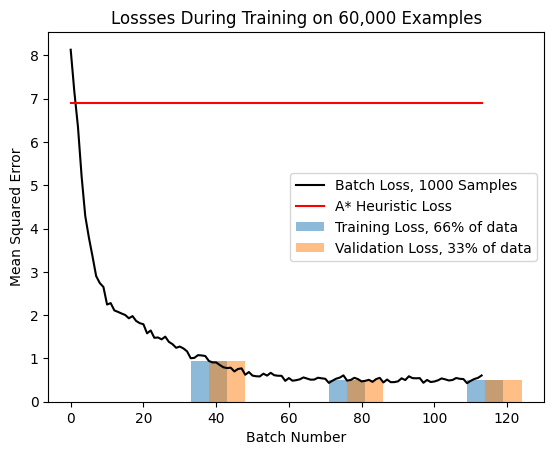

In [109]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
batch = list(range(len(batch_losses)))
start_batch = 0
validation_shift = 5*torch.ones(validation_losses.size()[0], dtype=int)
ax.plot(batch[start_batch:], batch_losses[start_batch:], color='black', label='Batch Loss, 1000 Samples')
# ax.scatter(epoch_losses[:,1], epoch_losses[:,0])
ax.bar(epoch_losses[:,1], epoch_losses[:,0], width=10, alpha=0.5, label='Training Loss, 66% of data')
ax.bar(validation_losses[:,1]+validation_shift, validation_losses[:,0], width=10, alpha=0.5, label='Validation Loss, 33% of data')
ax.plot(batch[start_batch:], (len(batch)-start_batch)*[heuristic_loss], color='r', label='A* Heuristic Loss')
ax.set_xlabel('Batch Number')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Lossses During Training on 60,000 Examples')
ax.legend()
plt.savefig('loss_plot.png')